# TP 2
Camille BROSSETTE  
Maxime LEGRAND

Nous avons suivi les directives données lors de la séance du 17 février, et contenues dans le sujet envoyé par e-mail a posteriori.

## Importation des données

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime

In [2]:
dft = {}
dft[1] = pd.read_pickle("../data_trades/strades_info_720.h5")
dft[2] = pd.read_pickle('../data_trades/strades_info_1102.h5')
dft[3] = pd.read_pickle('../data_trades/strades_info_1662.h5')
dft[4] = pd.read_pickle('../data_trades/strades_info_1664.h5')
dft[5] = pd.read_pickle('../data_trades/strades_info_2255.h5')
dft[6] = pd.read_pickle('../data_trades/strades_info_2574.h5')
dft[7] = pd.read_pickle('../data_trades/strades_info_2586.h5')
dft[8] = pd.read_pickle('../data_trades/strades_info_5685.h5')
dft[9] = pd.read_pickle('../data_trades/strades_info_8695864.h5')

## Nettoyage des données

In [3]:
for i in range(1,10):
    dti = dft[i]['ts_market'].iloc[0]
    dft[i] = dft[i][(dft[i]['bid'] < dft[i]['ask'])
                    &(dft[i]['bid'] != 0)
                    &(dft[i]['bid'] != 999999)
                    &(dft[i]['ask'] != 0)
                    &(dft[i]['ask'] != 999999)
                    &(dft[i]['volume'] != 0)
                    &(dft[i]['qty'] != 0)
                    &(dft[i]['side'] != 'U')]
    if i==2:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 7, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 15, 30))]
    else:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 8, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 16, 30))]

In [4]:
dftt = {}
for i in range(1,10):
    dftt[i] = dft[i].set_index('ts_market')

## Exploitation des données

In [5]:
def caracs(A):
    qty = A['qty'].resample('5Min', how='sum')
    qty = qty/qty.sum()
    
    trades = (A['qty']/A['qty']).resample('5Min', how='sum')
    trades = trades/trades.sum()
    
    meanprice = A['price'].resample('5Min', how='mean')
    meanprice = 100*meanprice/(meanprice.iloc[0])
    
    meanspread = (A['ask'] - A['bid']).resample('5Min', how='mean')
    meanspread = meanspread/meanspread.mean()
    
    vol = (((A['price']-A['price'].shift()).apply(lambda x: x**2)).resample('5Min', how='sum')).apply(np.sqrt)
    vol = vol/vol.mean()
    
    imb = abs(A['ask_size'] - A['bid_size']).resample('5Min', how='mean')
    imb = imb/imb.mean()
    
    simb = (A['ask_size'] - A['bid_size']).resample('5Min', how='mean')
    simb = simb/simb.mean()
    
    blq = (A['ask_size'] + A['bid_size']).resample('5Min', how='mean')
    blq = blq/blq.mean()
    
    return{"Volume" : qty, 
           "Trades" : trades, 
           "Mean price" : meanprice, 
           "Mean spread" : meanspread, 
           "Volatility" : vol, 
           "Imbalance" : imb,
           "Signed imbalance" : simb,
           "Best limits quantities" : blq}

## Représentation des données

In [6]:
Time = np.linspace(8,16.5,102)
C = {}
for i in range(1,10):
    C[i] = caracs(dftt[i])

In [7]:
def df_plot(data="Volume", range=range(1,10), sep=False, ncol=4):
    for i in range:
        plt.step(Time, C[i][data])
        plt.xlim(8,16.5)
        if sep==True:
            plt.title(data+" of trades set number "+str(i))
            plt.show()
        else:
            plt.title(data)
    plt.show()

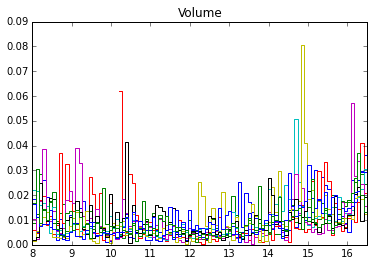

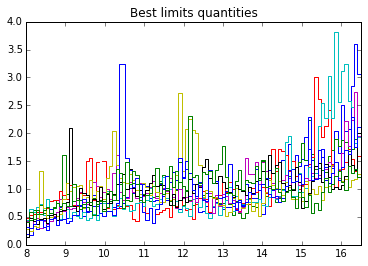

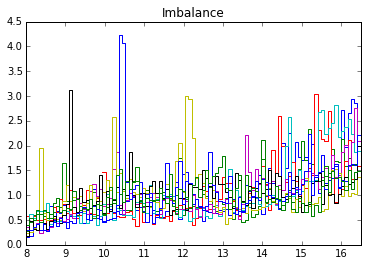

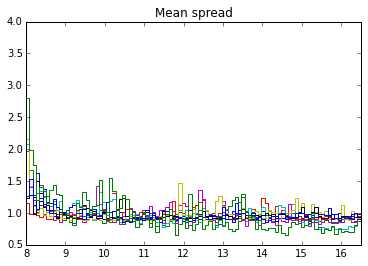

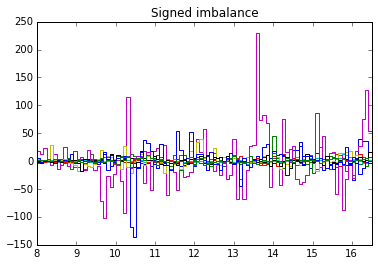

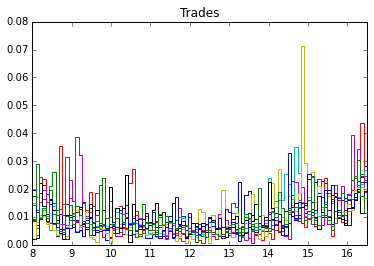

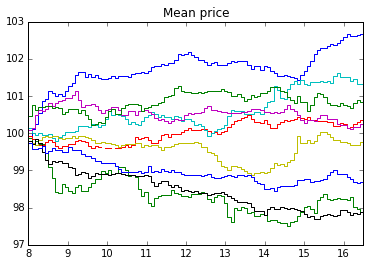

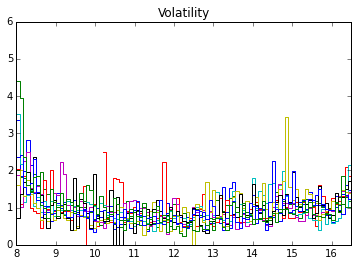

In [8]:
for c in C[1].keys():
    df_plot(data=c)

## Interprétations

- **Volume **  
    Les courbes de volume sont représentatives de la quantité d'actifs échangés. Sans surprise, elles présentent des extrémités relativement hautes (ordres en début de journée, et clôture des positions - par exemple des market makers - en fin de journée), avec un pic à l'ouverture du marché américain.
- **Trades**  
    Les courbes de trades sont relativement proches de celles de volume, à l'exception de quelques écarts marginaux dénotant une variation de la quantité moyenne échangée par trade.
- **Mean price**  
    Le mean price a été renormalisé de sorte que chaque courbe représente l'évolution d'un portefeuille contenant $100€$ à l'ouverture du marché. Chaque courbe ressemble alors à ce à quoi on a l'habitude pour la représentation sur prix sur une journée, sans grand rapport les unes avec les autres (mais montrant une tendance moyenne relativement stable).
- **Mean spread**  
    Les courbes de spread moyen sont relativement stable tout au long de la journée, à l'exception d'un pic à l'ouverture, pouvant probablement être interprété comme une prudence des deux côtés (Ask et Bid) qui rechignent à proposer des prix trop compétitifs avant d'avoir pris la température du marché en début de journée.
- **Volatility**  
    On a pris l'estimateur basique de volatilité haute fréquence, en signalant qu'il faille faire attention à ses dérives (représentées par le *signature plot*). Les courbes obtenues correspondent exactement à celle attendues après les présentations faites en cours et en TD : un U (grosse volatilité à l'ouverture et la fermeture) agrémenté par un pic à l'ouverture du marché américain.
- **Imbalance**  
    Ce qu'on appelle l'imbalance est ici la quantité $|Q_{ask}-Q_{bid}|$, relativement faible en début de journée (les positions, encore frileuses, sont presque symétriques) avant de croître de plus en plus dans la journée (illustrant les volontés individuelles d'opérer les achats ou ventes prévues pour la journée avant la fermeture du marché, de plus en plus indépendamment de ce que les autres font), avec des pics en cours de journée indiquant des déséquilibres entre offre et demande.
- **Signed imbalance**  
    $Q_{ask}-Q_{bid}$, assez proche en concept de l'imbalance, mais on tourne autour de 0, et les pics peuvent être plus facilement mis en parallèle avec la courbe des prix (et plus spécifiquement ses décalages).
- **Best limits quantities**  
    Les quantités *best limits* évoluent en début de journée comme l'imbalance (ce qui semble indiquer qu'alors les grosses quantités aux *best limits* sont provoquées par des acteurs déséquilibrant le *tradeoff* offre-demande), et le surpasse en fin de journée, indiquant des concessions de beaucoup d'acteurs qui se rejoignent aux *best limits* plutôt qu'attendre plus loin, de peur de ne pas faire les trades désirés avant la clôture.